In [1]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds 
#svds for sparse matrices

## Importing the dataset 

In [2]:
df=pd.read_csv("C:\\Users\\Srinivas\\Downloads\\archive (7)\\ratings_Electronics.csv",header=None)
df.head()

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [3]:
#as we see dataset does not have the header.
#let add the column names
df.columns=['user_id','product_id','rating','timestamp']
#let drop the timestamp column
df=df.drop('timestamp',axis=1)
#copying the data to another dataframe 
df_copy=df.copy(deep=True)
#lets print head
df_copy.head()

,user_id,product_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


## EDA - Exploratory Data Analysis

In [4]:
#lets start with EXPLORATORY DATA ANALYSIS 
#LET check for shape,datatype,missing values
rows,columns=df.shape
print("NUMBER OF ROWS=",rows)
print("NUMBER OF COLUMNS =",columns)


NUMBER OF ROWS= 7824482
NUMBER OF COLUMNS = 3


In [5]:
#DATATYPES 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   user_id     object 
 1   product_id  object 
 2   rating      float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [6]:
#FINDING MISSING VALUES IN EACH COLUMNS
df.isna().sum()

user_id       0
product_id    0
rating        0
dtype: int64

In [7]:
#LET GET SUMMARY OF THE 'rating' COLUMN
df['rating'].describe()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

### Rating distribution

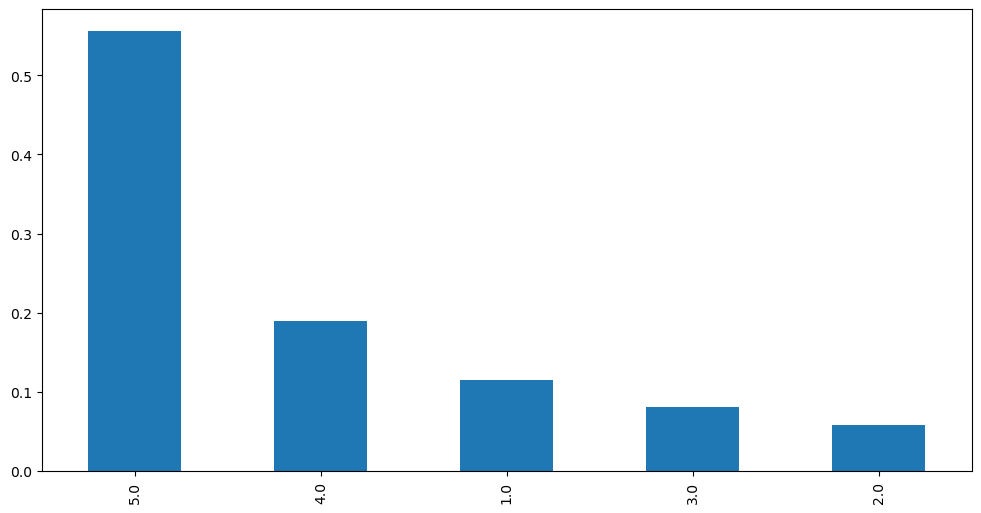

In [8]:
#LETS FIND THE RARING DISTRIBUTION
plt.figure(figsize=(12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

As the graph says, Over 50% of the ratings are 5,followed by a little below 20% with 4 star ratings.
And the ratings will go down until bwlow 10% of the ratings are 2 stars

In [9]:
#Lets check the Number of Unique Users and Items
print('Number od unique Users in data =',df['user_id'].nunique())
print('Number od unique Itemms in data =',df['product_id'].nunique())

Number od unique Users in data = 4201696
Number od unique Itemms in data = 476002


In [10]:
#Lets check the most Number of rating from Users
most_rated=df.groupby('user_id').size().sort_values(ascending=False)[:15]
most_rated

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
ARBKYIVNYWK3C     296
A22CW0ZHY3NJH8    292
A3EXWV8FNSSFL6    282
A38RMU1Y5TDP9     282
A3LGT6UZL99IW1    279
dtype: int64

In [11]:
# List of desired star ratings
desired_ratings = [5, 4, 3, 2, 1]

# Filter products with 5, 4, 3, 2, 1 star ratings
filtered_products = df[df['rating'].isin(desired_ratings)]['product_id'].unique()

print("Products with 5, 4, 3, 2, 1 star ratings:")
print(filtered_products)

Products with 5, 4, 3, 2, 1 star ratings:
['0132793040' '0321732944' '0439886341' ... 'BT008T2BGK' 'BT008UKTMW'
 'BT008V9J9U']


## Pre-Processing

Let's take a subset of the dataset (by only keeping the users who have given 50 or more ratings) to make the dataset less sparse and easy to work with.

In [12]:
counts_no=df['user_id'].value_counts()
df_final =df[df['user_id'].isin(counts_no[counts_no >= 50].index)]

In [13]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['product_id'].nunique())

The number of observations in the final data = 125871
Number of unique USERS in the final data =  1540
Number of unique PRODUCTS in the final data =  48190


### Checking the density of the rating matrix

In [14]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='product_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix 
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


product_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Rank Based Recommendation System 

In [15]:
#calutating the average rating for each product
avg_ratings=df_final.groupby('product_id').mean()['rating']

#calculating the count of rating for each product 
count_rating = df_final.groupby('product_id').count()['rating']

#create a dataframe with calculated average and count of rating 
final_rating =pd.DataFrame({'avg_rating':avg_ratings,'rating_count':count_rating})

#sorting the dataframe by average of rating
final_rating=final_rating.sort_values(by='avg_rating',ascending=False)
final_rating.head()

,avg_rating,rating_count
product_id,,
0594451647,5.0,1
B003RRY9RS,5.0,1
B003RR95Q8,5.0,1
B003RIPMZU,5.0,1
B003RFRNYQ,5.0,2


In [16]:
#defining funnction to get the top n products based on highest average rating and minimum interactions 
def top__n__products(final_rating,n,min_interaction):
    recommendations=final_rating[final_rating['rating_count']>min_interaction]
    recommendations=recommendations.sort_values('avg_rating',ascending=False)
    return recommendations.index[:n]

## Recommending top 10 products with 50 minimum interactions based on popularity

In [17]:
list(top__n__products(final_rating,10,50))

['B001TH7GUU',
 'B003ES5ZUU',
 'B0019EHU8G',
 'B006W8U2MU',
 'B000QUUFRW',
 'B000HPV3RW',
 'B001TH7GSW',
 'B000BQ7GW8',
 'B000N99BBC',
 'B002WE6D44']

## Recommending top 10 products with 100 minimum interactions based on popularity

In [18]:
list(top__n__products(final_rating,10,100))

['B003ES5ZUU',
 'B000N99BBC',
 'B007WTAJTO',
 'B002V88HFE',
 'B004CLYEDC',
 'B00834SJSK',
 'B0034CL2ZI',
 'B00834SJNA',
 'B00829TIEK',
 'B00829THK0']

# Collaborative Filtering based Recommendation System 

## User based collaborative filtering

In [19]:
final_ratings_matrix.head()

product_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


user_id (index) is of the object data type. Replace the user_id by numbers starting from 0 to 1539 (for all user ids) so that the index is of integer type and represents a user id in the same format

In [20]:
final_ratings_matrix['user_index']=np.arange(0,final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'],inplace=True)

final_ratings_matrix.head()

product_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Function to find Similar users and their similarity scores

In [21]:
#defining a functio to get similar users
def similar_users(user_index,interactions_matrix):
    similarity=[]
    for user in range(0,interactions_matrix.shape[0]):
        sim=cosine_similarity([interactions_matrix.loc[user_index]],[interactions_matrix.loc[user]])
        similarity.append((user,sim))
    
    similarity.sort(key=lambda x: x[1],reverse=True)
    most_similar_users=[tup[0] for tup in similarity]
    similarity_score=[tup[1] for tup in similarity]

    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])

    return most_similar_users,similarity_score



#### Finding out top 10 similar users to the user index 4 and their similarity score

In [22]:
similar=similar_users(4,final_ratings_matrix)[0][0:10]
similar

[1277, 466, 681, 1188, 733, 1227, 740, 456, 589, 1032]

In [23]:
#printing the similarity score
similar_users(4,final_ratings_matrix)[1][:10]

[array([[0.09627074]]),
 array([[0.08628048]]),
 array([[0.07370263]]),
 array([[0.07068153]]),
 array([[0.06670813]]),
 array([[0.0652768]]),
 array([[0.06512579]]),
 array([[0.06296924]]),
 array([[0.06295681]]),
 array([[0.06264194]])]

#### Finding out top 10 similar users to the user index 1521 and their similarity score

In [24]:
similar=similar_users(1521,final_ratings_matrix)[0][:10]
similar

[991, 1065, 1012, 1402, 1371, 1278, 1518, 692, 785, 161]

In [25]:
#printinf the similarity score
similar_users(1521,final_ratings_matrix)[1][:10]

[array([[0.10889304]]),
 array([[0.10538068]]),
 array([[0.1026758]]),
 array([[0.09418291]]),
 array([[0.09149062]]),
 array([[0.09135361]]),
 array([[0.09028898]]),
 array([[0.08735684]]),
 array([[0.08673386]]),
 array([[0.08478815]])]

### Function to recommend products

In [26]:
# defining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix):
    
    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]
    
    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []
    
    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:
            
            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break
    
    return recommendations[:num_of_products]

#### Recommend 5 products to user index 5 based on similarity based collaborative filtering

In [27]:
recommendations(5,5,final_ratings_matrix)

['B00BEHQKP2', 'B00JKM0EQE', 'B002R5AM7C', 'B00EXK1L38', 'B000FFI2AU']

#### Recommend 10 products to user index 1521 based on similarity based collaborative filtering

In [28]:
recommendations(1521,10,final_ratings_matrix)

['B0028AD7BE',
 'B005LIDMYM',
 'B0079TOEQQ',
 'B007BY0MIS',
 'B0040XQ7PK',
 'B001DZVS52',
 'B009O7XGCY',
 'B007X3VEUW',
 'B007WVA2PI',
 'B00DQZQG3G']

# Model based Collaborative Filtering: Singular Value Decomposition 

**We have seen above that the interaction matrix is highly sparse. SVD is best to apply on a large sparse matrix. Note that for sparse matrices, we can use the sparse.linalg.svds() function to perform the decomposition**

Also, we will use **k=50 latent features** to predict rating of products

## CSR matrix


In [29]:
from scipy.sparse import csr_matrix
final_ratings_sparse = csr_matrix(final_ratings_matrix.values)


## SVD

In [30]:
U, s, Vt = svds(final_ratings_sparse, k = 50) # here k is the number of latent features
sigma = np.diag(s)

In [31]:
U.shape

(1540, 50)

In [32]:
sigma.shape

(50, 50)

In [33]:
Vt.shape

(50, 48190)

Now, let's regenerate the original matrix using U, Sigma, and Vt matrices. The resulting matrix would be the predicted ratings for all users and products

## Predicting ratings

In [34]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma),Vt)

prediction_df=pd.DataFrame(abs(all_user_predicted_ratings),columns = final_ratings_matrix.columns)
prediction_df.head()
prediction_matrix = csr_matrix(prediction_df.values)

## Function to recommend products

In [35]:
import numpy as np

def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):
    
    # Get the user's ratings from the actual and predicted interaction matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')
    
    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]   
    
    #Recommending products with top predicted ratings
    temp = temp.sort_values('user_predictions',ascending=False)#Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))


### Recommending top 5 products to user id 45

In [36]:
#Enter 'user index' and 'num_recommendations' for the user
recommend_items(45,final_ratings_sparse,prediction_matrix,5)


Below are the recommended products for user(user_id = 45):

Recommended Products
38250    0.498265
18891    0.427067
12997    0.384615
10601    0.380070
11870    0.373620
Name: user_predictions, dtype: float64


### Recommending top 10 products to user id 110

In [37]:
recommend_items(110,final_ratings_sparse,prediction_matrix,10)


Below are the recommended products for user(user_id = 110):

Recommended Products
28761    1.482331
28762    1.151833
23378    1.138376
34628    0.983351
39003    0.938928
33819    0.787063
25554    0.619888
5317     0.611817
22602    0.591355
38599    0.548141
Name: user_predictions, dtype: float64


## Evaluating the model

In [38]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

product_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
average_rating=final_ratings_matrix.mean()
average_rating.head()

product_id
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [40]:
prediction_df.head()

product_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,0.061477,0.001214,0.123433,0.028490,0.016109,0.002855,0.174568,0.011367,0.012997
1,0.002286,0.010898,0.000724,0.130259,0.007506,0.003350,0.063711,0.000674,0.016111,0.002433,...,0.000038,0.013766,0.001473,0.025588,0.042103,0.004251,0.002177,0.024362,0.014765,0.038570
2,0.001655,0.002675,0.007355,0.007264,0.005152,0.003986,0.003480,0.006961,0.006606,0.002719,...,0.001708,0.051040,0.000325,0.054867,0.017870,0.004996,0.002426,0.083928,0.112205,0.005964
3,0.001856,0.011019,0.005910,0.014134,0.000179,0.001877,0.005391,0.001709,0.004968,0.001402,...,0.000582,0.009326,0.000465,0.048315,0.023302,0.006790,0.003380,0.005460,0.015263,0.025996
4,0.001115,0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,0.019347,0.012749,0.001026,0.001364,0.020580,0.011828,0.012770


In [41]:
avg_prediction=prediction_df.mean()
avg_prediction.head()

product_id
0594451647    0.003360
0594481813    0.005729
0970407998    0.008566
0972683275    0.035330
1400501466    0.006966
dtype: float64

In [42]:
rmse_df=pd.concat([average_rating,avg_prediction],axis=1)
rmse_df.columns=['Avg_actual_ratings','Avg_Predicted_ratings']
rmse_df.head()

,Avg_actual_ratings,Avg_Predicted_ratings
product_id,,
0594451647,0.003247,0.003360
0594481813,0.001948,0.005729
0970407998,0.003247,0.008566
0972683275,0.012338,0.035330
1400501466,0.012987,0.006966


In [43]:
RMSE=mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_Predicted_ratings'], squared=False)
print(f'RMSE SVD Model = {RMSE} \n')

RMSE SVD Model = 0.013679389779858008 

